In [1]:
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [62]:
np.random.seed(123456)
nsite = 200
nrep = 10
x = np.linspace(-2.5, 2.5, nsite, dtype=np.float32).reshape(-1,1)

# Draw f(x) from a Gaussian process
def kernel(x, theta):
    m, n = np.meshgrid(x, x)
    sqdist = abs(m-n)**2
    return np.exp(- theta * sqdist)

K = kernel(x, theta=.2)
L = np.linalg.cholesky(K + 1e-5* np.eye(nsite))
f_prior = np.dot(L, np.random.normal(size=(nsite, 1)))


Text(0, 0.5, 'True (latent) abundance')

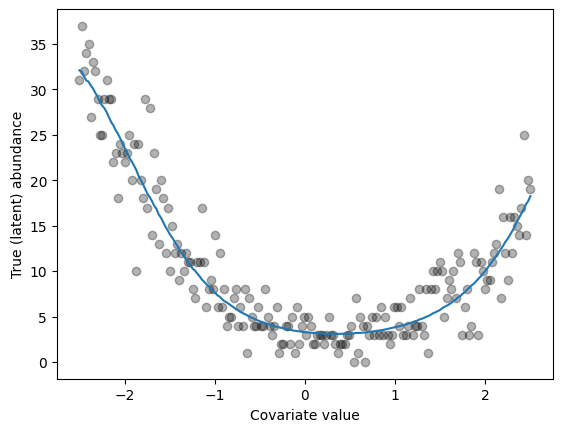

In [63]:
offset = 3
lam = np.exp(f_prior + offset)
n = np.random.poisson(lam)

plt.scatter(x, n, c='k', alpha=.3)
plt.plot(x, lam)
plt.xlabel('Covariate value')
plt.ylabel('True (latent) abundance')

Text(0, 0.5, 'Observed counts')

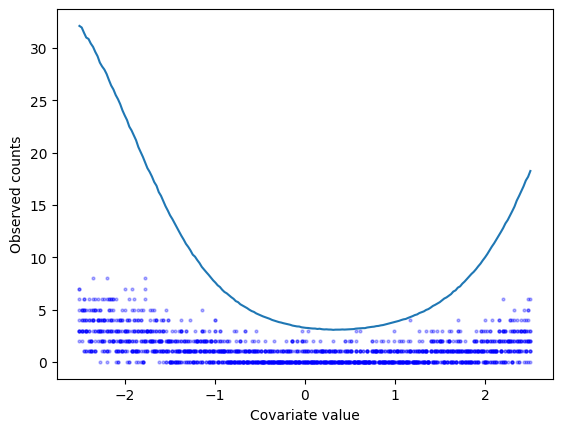

In [64]:
pr_detection = 1 / (1+np.e**(-((x/20)**2) + 2)) #np.array([0.5])
y = np.random.binomial(n=n, 
                       p=pr_detection, 
                       size=(nsite, nrep))

plt.plot(x, lam)
for i in range(nrep):
    plt.scatter(x, y[:, i], c='b', s=4, alpha=.3)    
plt.xlabel('Covariate value')
plt.ylabel('Observed counts')

In [65]:
class Net(nn.Module):
    """ Neural N-mixture model 
    
    This is a neural network that ingests x and outputs:
    - lam(bda): expected abundance
    - p: detection probability
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        hidden_layer = torch.sigmoid(self.fc1(x))
        output = self.fc2(hidden_layer)
        lam = torch.exp(output[:, [0]])
        p = torch.sigmoid(output[:, [1]])
        return lam, p
    

In [66]:
def nmix_loss(y_obs, lambda_hat, p_hat, n_max):
    """ N-mixture loss.
    
    Args:
      y_obs (tensor): nsite by nrep count observation matrix
      lambda_hat (tensor): poisson abundance expected value
      p_hat (tensor): individual detection probability
      n_max (int): maximum abundance to consider
    
    Returns:
      negative log-likelihood (tensor)
    """
    batch_size, n_rep = y_obs.shape
    
    possible_n_vals = torch.arange(n_max).unsqueeze(0)
    n_logprob = torch.distributions.poisson.Poisson(lambda_hat).log_prob(possible_n_vals)
    assert n_logprob.shape == (batch_size, n_max)
    
    y_dist = torch.distributions.binomial.Binomial(
      possible_n_vals.view(1, 1, -1), 
      probs=p_hat.view(-1, 1, 1), 
      validate_args=False
    )
    y_obs = y_obs.unsqueeze(-1).repeat(1, 1, n_max)
    y_logprob = y_dist.log_prob(y_obs).sum(dim=1) # sum over repeat surveys
    assert y_logprob.shape == (batch_size, n_max)
    
    log_lik = torch.logsumexp(n_logprob + y_logprob, -1)
    return -log_lik



In [67]:
net = Net(hidden_size=32)
net

Net(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [68]:
from torch.utils.data import DataLoader, TensorDataset
import multiprocessing
dataset = TensorDataset(torch.tensor(x).float(), torch.tensor(y))
dataloader = DataLoader(dataset, 
                        batch_size=16,
                        shuffle=True, 
                        num_workers=1) #multiprocessing.cpu_count()


In [69]:
n_epoch = 50
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6)
running_loss = []


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


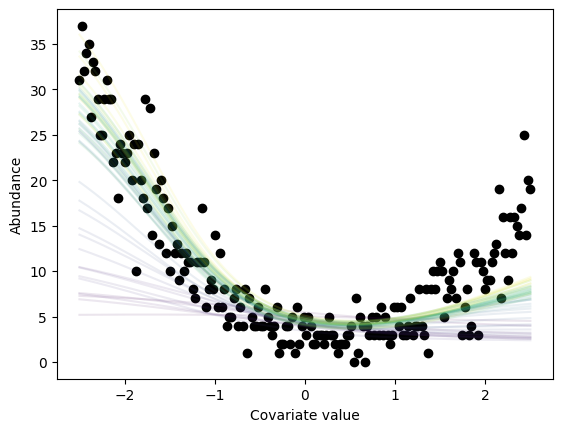

In [70]:
_ = plt.scatter(x, n, c='k')
_ = plt.xlabel('Covariate value')
_ = plt.ylabel('Abundance')
colors = plt.cm.viridis(np.linspace(0,1,n_epoch))
for i in tqdm(range(n_epoch)):
    for i_batch, xy in enumerate(dataloader):
        x_i, y_i = xy
        optimizer.zero_grad()
        lambda_i, p_i = net(x_i)
        nll = nmix_loss(y_i, lambda_i, p_i, n_max = 200)
        loss = torch.mean(nll)        
        loss.backward()
        optimizer.step()    # Does the update
        running_loss.append(loss.data.detach().numpy())
    lam_hat, p_hat = net(torch.from_numpy(x))
    lam_hat = lam_hat.detach().numpy()
    _ = plt.plot(x, lam_hat, color=colors[i], alpha=.1)
plt.show()


## presence / absence

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

np.random.seed(123456)
nsite, nrep = 200, 50

# 1) site‐level covariate
x1 = np.linspace(-2.5, 2.5, nsite, dtype=np.float32).reshape(-1, 1)
x2 = np.random.normal(-2, 10, size=nsite).astype('float32').reshape(-1, 1)
# x3 = np.linspace(5, 10, nsite, dtype=np.float32).reshape(-1, 1)
x = np.stack([x1, x2], axis=-1)

# # 2) GP draw for log‐odds of occupancy
# def generate_eta(x):
#     def kernel(x, theta):
#         m, n = np.meshgrid(x, x)
#         return np.exp(-theta * (m - n)**2)

#     K = kernel(x, theta=0.2)
#     L = np.linalg.cholesky(K + 1e-5*np.eye(nsite))
#     f_prior = L @ np.random.normal(size=(nsite, 1))
#     eta = f_prior  # plus any intercept
#     return eta

psi = 1 / (1 + np.exp(-(3*(x1) + -3 * (x2))/10))  # site‐level occupancy prob
occ = np.random.binomial(1, psi)     # true occupancy

# 3) simulate survey‐level effort (e.g., hours spent or observer count)
#    here we draw effort ∼ Uniform(0.5, 3.0) hours
effort = np.random.uniform(0.5, 3.0, size=(nsite, nrep, 2)).astype(np.float32) # 2 detection variables

# 4) build detection probability as a function of BOTH x and effort
# x_rep = np.repeat(x, nrep, axis=1)   # now (nsite, nrep)

logit_p = (0.0
           + 0.5*(x[...,0]/2) # effect of site covariate on detection
           + 1*effort[...,0]
           - 1*effort[...,1]) # effect of effort on detection
p = 1 / (1 + np.exp(-logit_p))       # (nsite, nrep)

# 5) simulate observed detections y_ij ~ Bernoulli(z_i * p_ij)
#    reshape occ so it can broadcast
occ_mat = occ.reshape(-1, 1)         # (nsite, 1)
y = np.random.binomial(n=occ_mat, p=p)  # (nsite, nrep)


In [2]:
x.shape

(200, 1, 2)

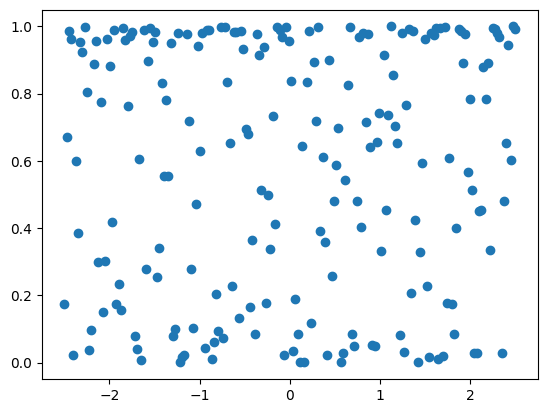

In [3]:
plt.scatter(x1, psi)

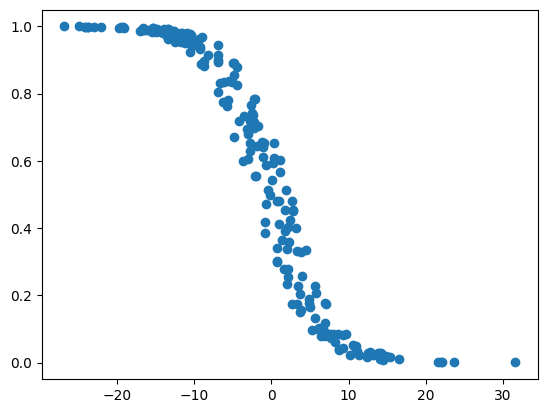

In [4]:
plt.scatter(x2, psi)

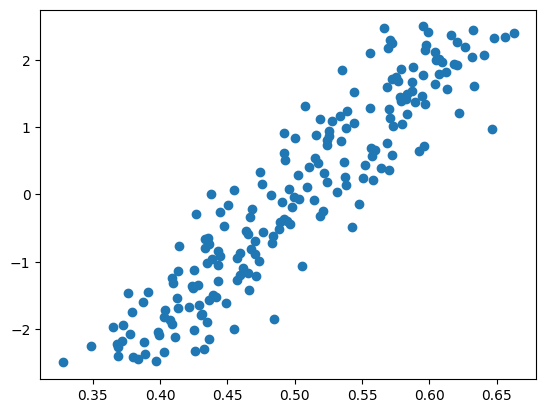

In [5]:
plt.scatter(p.mean(axis=1), x1)

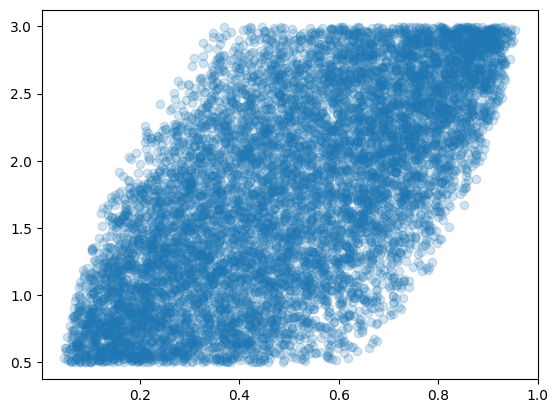

In [6]:
plt.scatter(p.flatten(), effort[...,0].flatten(), alpha=0.2)

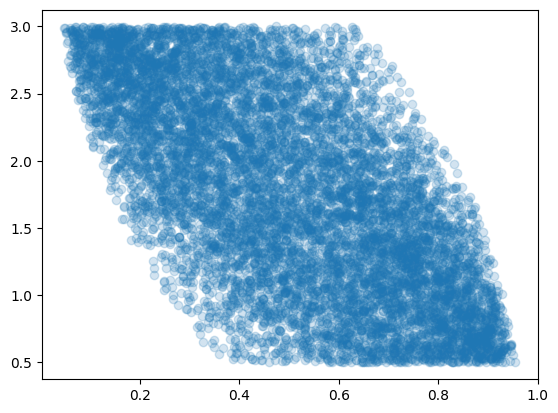

In [7]:
plt.scatter(p.flatten(), effort[...,1].flatten(), alpha=0.2)

Text(0.5, 1.0, 'Occupancy')

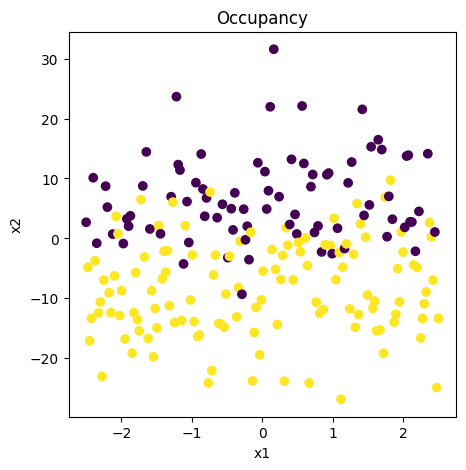

In [8]:
# Flatten for plotting
x1_flat = x1.flatten()
x2_flat = x2.flatten()

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# 1) Scatter of occupancy on the covariate surface
sc = ax.scatter(x1_flat, x2_flat, c=occ, marker='o')
# ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Occupancy')


Text(0.5, 1.0, 'Occupancy')

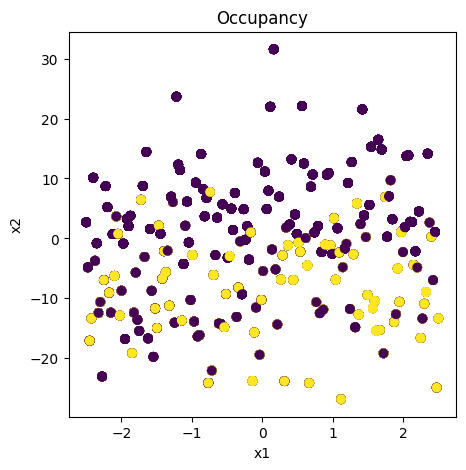

In [9]:
# Flatten for plotting
x1_flat = x1.flatten()
x2_flat = x2.flatten()

# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# 1) Scatter of occupancy on the covariate surface
for i in range(y.shape[1]):
    sc = ax.scatter(x1_flat, x2_flat, c=y[:,i], marker='o')
# ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Occupancy')


In [19]:
class Net(nn.Module):
    """ Neural N-mixture model 
    
    This is a neural network that ingests x and outputs:
    - psi(bda): expected occupancy
    - p: detection probability
    """
    def __init__(self, input_size_occ=2, hidden_size_occ=32, additiona_input_size_det=2, hidden_size_det=32):
        super().__init__()
        self.occ_fc1 = nn.Linear(input_size_occ, hidden_size_occ)
        self.occ_fc2 = nn.Linear(hidden_size_occ, 1)

        self.det_fc1 = nn.Linear(input_size_occ + additiona_input_size_det, hidden_size_det)
        self.det_fc2 = nn.Linear(hidden_size_det, 1)
        
    def forward(self, x, w): # site level covariates, repeat level covariates
        occ_h1 = torch.sigmoid(self.occ_fc1(x))
        occ = torch.sigmoid(self.occ_fc2(occ_h1))
        
        batch, nrep, _ = w.shape
        x_rep = x.expand(-1, nrep, -1)      # (batch,nrep,1)
        inp_p = torch.cat([x_rep, w], dim=-1)            # (batch,nrep,1+cov)
        det_h1 = torch.sigmoid(self.det_fc1(inp_p))
        det = torch.sigmoid(self.det_fc2(det_h1)).squeeze(-1) # (batch,nrep)

        return occ, det # psi, p
    

In [20]:
def occ_loss(y_obs, psi_hat, p_hat):
    """ N-mixture loss.
    
    Args:
      y_obs (tensor): nsite by nrep count observation matrix
      psi_hat (tensor): occupancy expected value
      p_hat (tensor): individual detection probability
    
    Returns:
      negative log-likelihood (tensor)
    """
    # eps = 1e-16
    # psi_hat = psi_hat.clamp(eps, 1-eps)
    # p_hat = p_hat.clamp(eps, 1-eps)
    
    batch_size, n_rep = y_obs.shape
    mask = (y_obs != -1).float()
    y_valid = y_obs * mask
    
    z_vals = torch.tensor([0.0, 1.0]).view(1, 2) # possible_z_vals
    z_logprob = torch.distributions.Bernoulli(probs=psi_hat).log_prob(z_vals) # (batch_size, 2)
    
    all_zero = (y_valid.sum(dim=1) == 0) # shape = (batch_size,), bool
        
    inf = float('inf')
    loglik_y_given_z0 = torch.where(all_zero, 
                                    torch.zeros(batch_size),  # log(1)=0
                                    -inf * torch.ones(batch_size))

    log_p    = torch.log(p_hat.clamp(min=1e-8))       # → (batch_size,)
    log_1mp  = torch.log((1-p_hat).clamp(min=1e-8))   # → (batch_size,)
    # log_p_expand   = log_p.view(batch_size, 1)       # → (batch_size, 1)
    # log_1mp_expand = log_1mp.view(batch_size, 1)     # → (batch_size, 1)
    term_rep = y_obs * log_p + (1 - y_obs) * log_1mp
    term_rep = term_rep * mask # masked
    loglik_y_given_z1 = term_rep.sum(dim=1)  
    
    y_logprob = torch.stack(
        [loglik_y_given_z0,    # (batch_size,)
        loglik_y_given_z1],   # (batch_size,)
        dim=1                   # → (batch_size, 2)
    )

    joint_logprob = z_logprob.squeeze(-2) + y_logprob   # shape = (batch_size, 2)
    log_lik_per_site = torch.logsumexp(joint_logprob, dim=1)  # → (batch_size,)

    return -log_lik_per_site



In [21]:
net = Net(input_size_occ=2, hidden_size_occ=32, additiona_input_size_det=2, hidden_size_det=32)
net

Net(
  (occ_fc1): Linear(in_features=2, out_features=32, bias=True)
  (occ_fc2): Linear(in_features=32, out_features=1, bias=True)
  (det_fc1): Linear(in_features=4, out_features=32, bias=True)
  (det_fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [22]:
from torch.utils.data import DataLoader, TensorDataset
import multiprocessing

# dataset = TensorDataset(torch.tensor(x).float(),
#                         torch.where((torch.rand(size=y.shape) + 0.2) > 0.5, torch.tensor(y), torch.tensor(-1))) # randomly missing some repeat


dataset = TensorDataset(
    torch.tensor(x).float(),                   # (nsite,1)
    torch.tensor(effort).float(),                   # (nsite,nrep,1)
    torch.where((torch.rand(size=y.shape)+0.2)>0.5,
                torch.tensor(y),
                torch.tensor(-1))         # (nsite,nrep)
)

dataloader = DataLoader(dataset, 
                        batch_size=16,
                        shuffle=True, 
                        num_workers=1) #multiprocessing.cpu_count()



In [23]:
def get_ellipse(x1, x2, occ):
    # Extract presence points
    points = np.vstack([x1[occ == 1], x2[occ == 1]])  # shape (2, N_presence)

    # Minimum Volume Enclosing Ellipse (Khachiyan's algorithm with regularization)
    def min_enclosing_ellipse(P, tol=1e-3, reg=1e-6):
        N = P.shape[1]
        d = 2
        Q = np.vstack([P, np.ones((1, N))])
        u = np.ones(N) / N
        err = 1
        while err > tol:
            X = Q @ np.diag(u) @ Q.T
            # Regularize X to avoid singularity
            X += reg * np.eye(d + 1)
            M = np.diag(Q.T @ np.linalg.inv(X) @ Q)
            j = np.argmax(M)
            step = (M[j] - d - 1) / ((d + 1) * (M[j] - 1))
            new_u = (1 - step) * u
            new_u[j] += step
            err = np.linalg.norm(new_u - u)
            u = new_u
        center = P @ u
        cov = (P @ np.diag(u) @ P.T) - np.outer(center, center)
        cov += reg * np.eye(d)  # regularize covariance
        A = np.linalg.inv(cov) / d
        return center, A

    center, A = min_enclosing_ellipse(points)

    # Eigen-decomposition for ellipse axes
    eigvals, eigvecs = np.linalg.eigh(A)
    axes_lengths = 1 / np.sqrt(eigvals)  # lengths along eigenvectors

    # Parametric boundary of ellipse
    theta = np.linspace(0, 2 * np.pi, 200)
    ellipse_boundary = center.reshape(2, 1) + eigvecs @ np.diag(axes_lengths) @ np.vstack([np.cos(theta), np.sin(theta)])
    return ellipse_boundary


In [24]:
n_epoch = 50
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)
running_loss = []


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


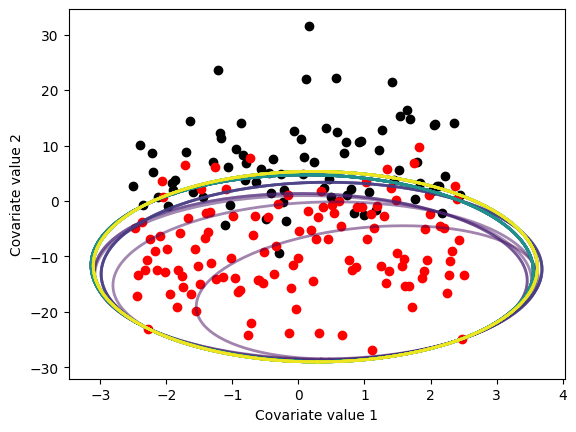

In [25]:
_ = plt.scatter(x1[occ==0], x2[occ==0], color='black')
_ = plt.scatter(x1[occ==1], x2[occ==1], color='red')
_ = plt.xlabel('Covariate value 1')
_ = plt.ylabel('Covariate value 2')

colors = plt.cm.viridis(np.linspace(0,1,n_epoch))
for i in tqdm(range(n_epoch)):
    for i_batch, xy in enumerate(dataloader):
        x_i, w_i, y_i = xy
        optimizer.zero_grad()
        psi_i, p_i = net(x_i, w_i)
        nll = occ_loss(y_i, psi_i, p_i)
        loss = torch.mean(nll)
        loss.backward()
        optimizer.step()    # Does the update
        running_loss.append(loss.data.detach().numpy())
    psi_hat, p_hat = net(torch.from_numpy(x), torch.from_numpy(effort))
    psi_hat = psi_hat.detach().numpy()
    modeled_occ = (psi_hat.squeeze(-2)>0.5).astype('int')
    if sum(modeled_occ)==0:
        continue
    ellipse_boundary = get_ellipse(x1, x2, modeled_occ) # remove the nrep dimension
    _ = plt.plot(ellipse_boundary[0], ellipse_boundary[1], color=colors[i], linewidth=2, alpha=.5)

plt.show()


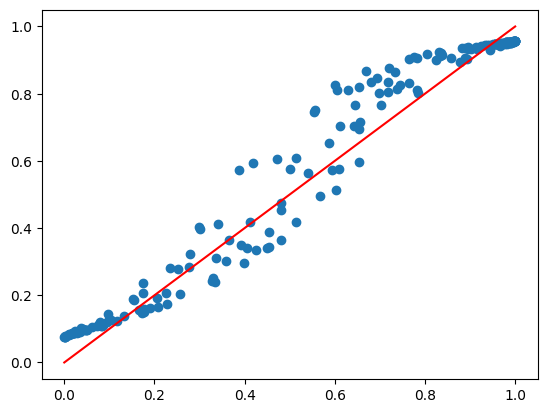

In [35]:
plt.scatter(psi, psi_hat.squeeze(-2))
plt.plot([0,1], [0,1], c='red')


In [39]:
p.shape

(200, 50)

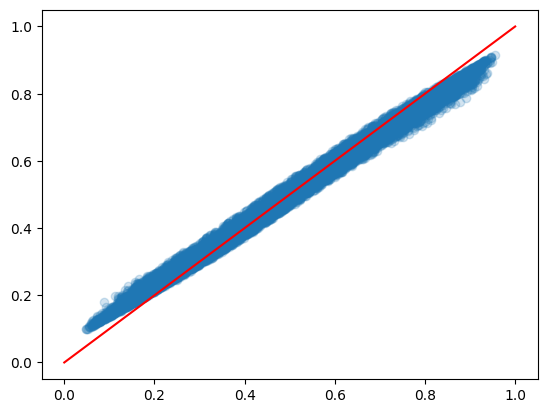

In [44]:
plt.scatter(p.flatten(), p_hat.detach().numpy().flatten(), alpha=0.2)
plt.plot([0,1], [0,1], c='red')


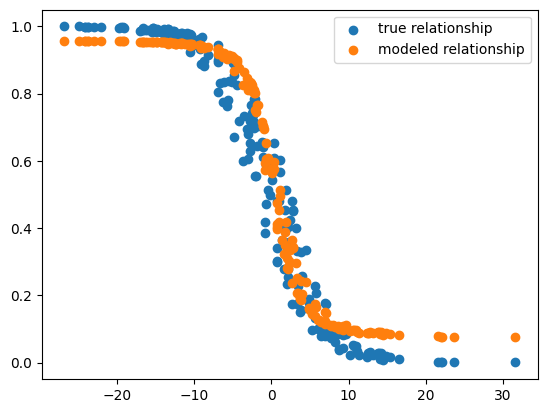

In [50]:
plt.scatter(x2, psi, label='true relationship')
plt.scatter(x2, psi_hat, label='modeled relationship')
plt.legend()


In [53]:
p_hat.shape

torch.Size([200, 50])

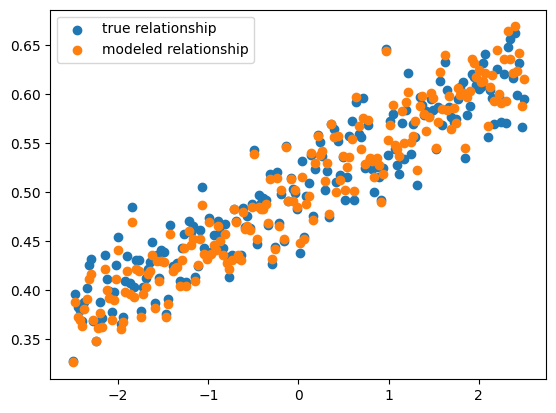

In [54]:
plt.scatter(x1, p.mean(axis=1), label='true relationship')
plt.scatter(x1, p_hat.detach().numpy().mean(axis=1), label='modeled relationship')
plt.legend()


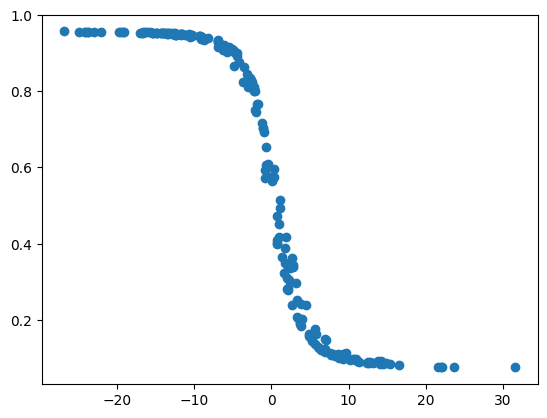